# FLEX scRNA pilot
## Doublet identification - Scrublet
- Author: Jacopo Umberto Verga, Kane Foster
- Date: 26/March/2025

I received the pre-processed data, now I am going to run the doublet identification pipeline. First tool:
- [Scrublet](https://github.com/swolock/scrublet)

In [1]:
#Import dependencies
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scrublet as scr
from scipy import io
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

Define a functions to load data and run `scrublet`

In [3]:
def list_files(input_dir):
    samples = os.listdir(input_dir)
    return samples

def create_out_dir(out_dir, sample_name):
    output_dir = out_dir + '/' + sample_name + '/Scrublet/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

def load_sparse_matrix(file_path):
    adata=sc.read_10x_h5(file_path+'/sample_filtered_feature_bc_matrix.h5')
    sparsematrix = adata.X
    cell_names=adata.obs_names.values
    return sparsematrix, cell_names


def run_scrublet(sparsematrix, threshold='auto'):
    scrub = scr.Scrublet(sparsematrix)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    if threshold=='auto':
        pass
    else:
        predicted_doublets = scrub.call_doublets(threshold=threshold)
    return doublet_scores, predicted_doublets, scrub


def write_results(cell_names, doublet_scores, predicted_doublets,output_dir,sample_name):
    data = np.array([cell_names,doublet_scores,predicted_doublets])
    df = pd.DataFrame(data=data).T
    df = df.rename(columns =  {0:'Cell',1:'doublet_scores',2:'predicted_doublets'})
    df.to_csv(output_dir + sample_name + '_Scrublet_results.csv', index = False)


def plot_results(scrub, output_dir, sample_name):
    scrub.plot_histogram()
    plt.gcf()
    plt.savefig(output_dir + sample_name + '_Scrublet_Histogram.pdf')
    plt.show()
    #Plot UMAP
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    scrub.plot_embedding('UMAP', order_points=True)
    plt.gcf()
    plt.savefig(output_dir + sample_name + '_Scrublet_UMAP.pdf')
    plt.show()
    print('\n\n\n')


def main(input_dir, out_dir, threshold='auto'):
    files = list_files(input_dir)
    scrub_thresholds={}
    for file in files:
        sample_name = file.split('.')[0]
        print(sample_name)
        file_path  = input_dir + '/' + file
        output_dir = create_out_dir(out_dir, sample_name)
        sparsematrix, cell_names = load_sparse_matrix(file_path)
        doublet_scores, predicted_doublets, scrub = run_scrublet(sparsematrix, threshold=threshold)
        scrub_thresholds[sample_name]=scrub.threshold_
        write_results(cell_names, doublet_scores, predicted_doublets,output_dir,sample_name)
        plot_results(scrub, output_dir, sample_name)
    return scrub_thresholds

In [6]:
!rm ../data/cellranger//.DS_Store

BS-21-E23779  BS-21-K19232  BS-22-E02713
BS-21-G52846  BS-21-X68276  BS-22-T49396


BS-22-E02713
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 60.0%
Elapsed time: 3.9 seconds


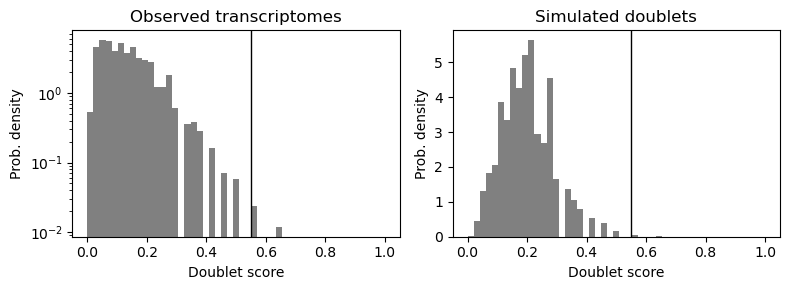

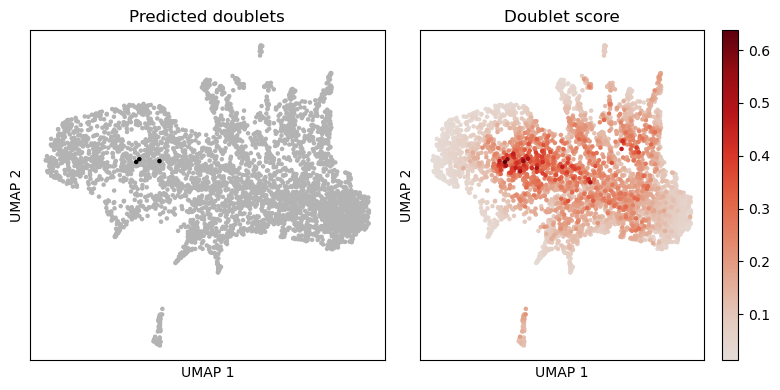





BS-22-T49396
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 9.4 seconds


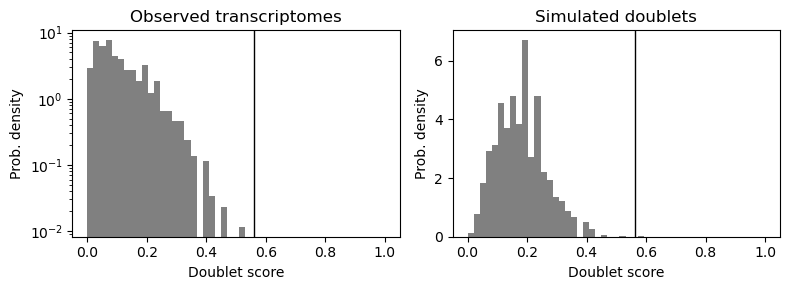

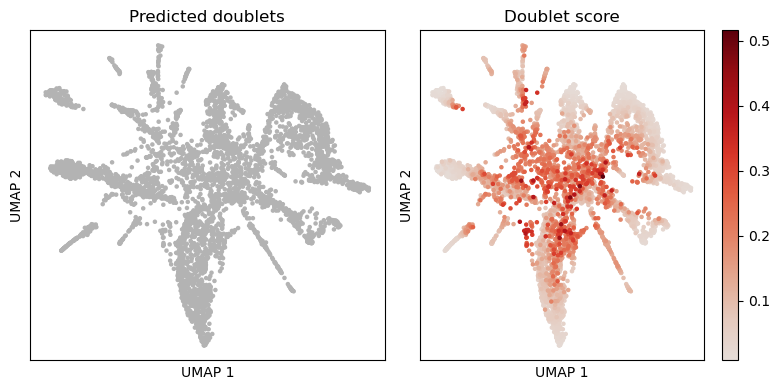





BS-21-G52846
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 5.2 seconds


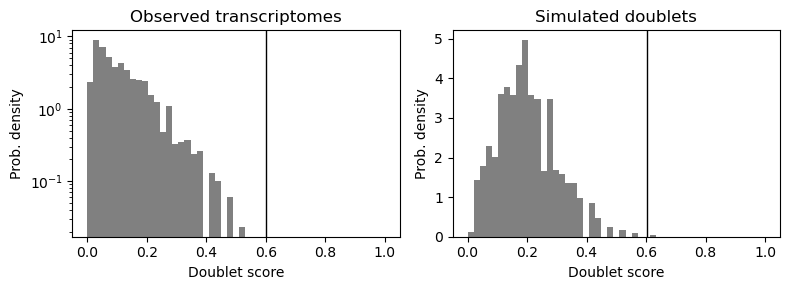

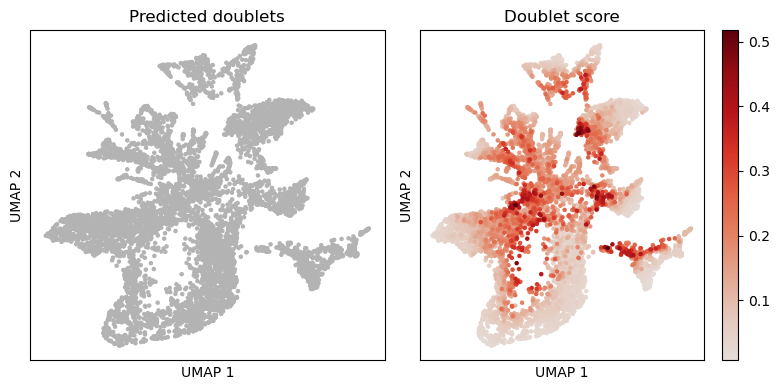





BS-21-K19232
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.18
Detected doublet rate = 23.0%
Estimated detectable doublet fraction = 55.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 41.5%
Elapsed time: 49.0 seconds


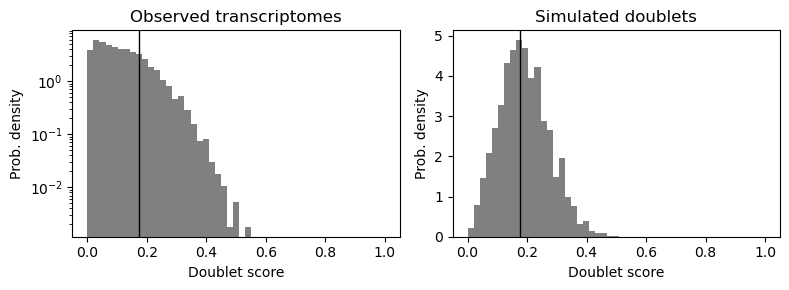

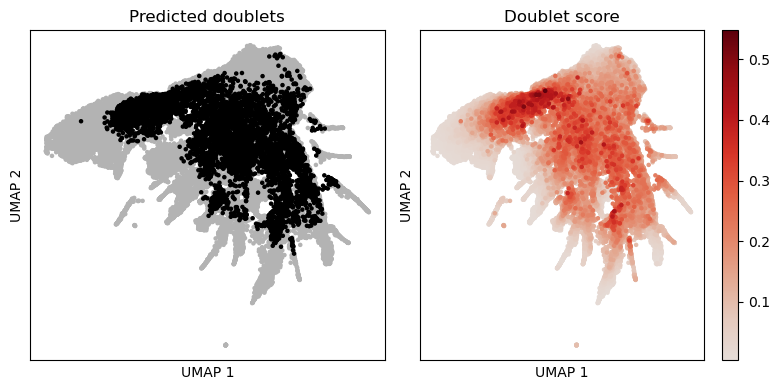





BS-21-X68276
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.7%
Elapsed time: 2.1 seconds


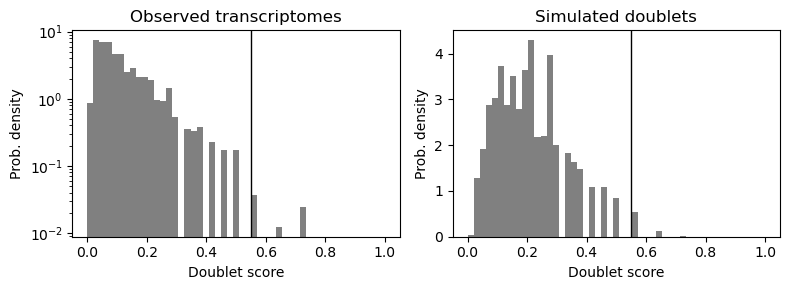

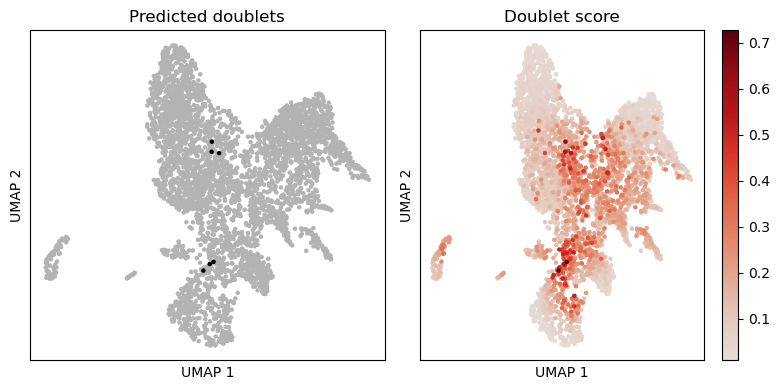





BS-21-E23779
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 20.6%
Elapsed time: 7.9 seconds


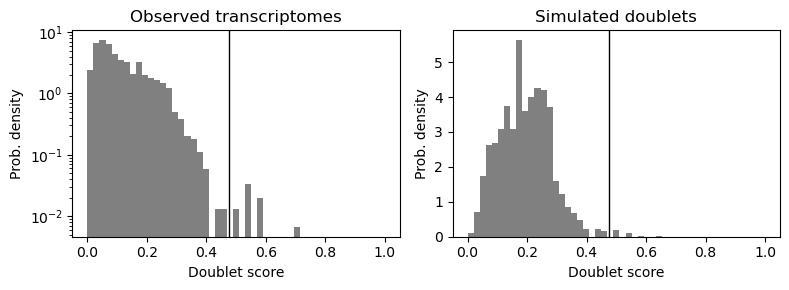

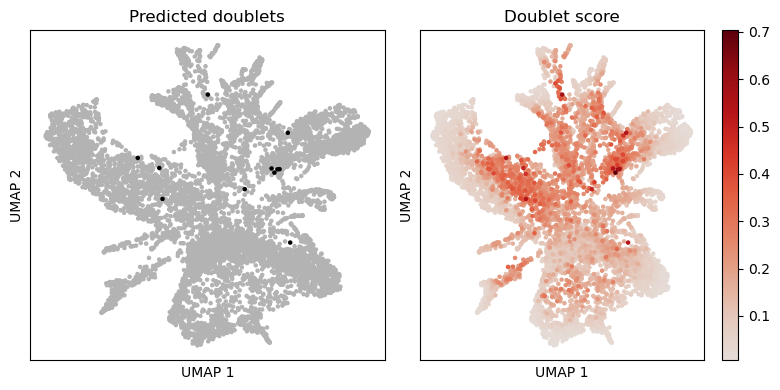

In [7]:
input_dir='../data/cellranger/'
out_dir='../out'`
scrub_thresholds = main(input_dir, out_dir)

In [8]:
log_dir='../logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

thresholds = pd.DataFrame.from_dict(scrub_thresholds, orient='index')
thresholds.columns = ['scrublet_threshold']
thresholds.to_csv(log_dir + 'scrublet_thresholds.csv')